In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from math import ceil,sin,cos, atan2, pi, sqrt
import pandas as pd
from cartopy import crs, feature
import requests
from bs4 import BeautifulSoup

In [5]:
import geocoder # pip install geocoder
def locat_coord(Name,province):
    g = geocoder.bing(Name+' '+province, key=APIkey)
    results = g.json
    return results['lat'], results['lng']

In [6]:
APIkey = 'Apex3rPr59EmaffYxKvl4Ypz0tjZBthExXiz1Ha_pBDtD3Q7XL7l2nMs2Ba8fwZm '

# Pulling official data from Wikipedia 2021 updated census
url = 'https://en.wikipedia.org/wiki/List_of_municipalities_in_British_Columbia'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[:-10]

Name = Data['Name'].iloc[:,0]
Pop = Data['2021 Canadian census[11]'].iloc[:,0]

d = {'Name': Name, 'Population':np.array(Pop)}
Urban = pd.DataFrame(data=d)

In [7]:
# Pulling official data from Washington Population Dataset
url = 'https://mrsc.org/Home/Research-Tools/Washington-City-and-Town-Profiles.aspx'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"full city-county-data table-interactive"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[0::3]

Name = Data['City']
Pop = Data['Population (2022)']
popu = []
for po in Pop:
    popu.append(int(po))
d = {'Name': Name, 'Population':popu}
Urban2 = pd.DataFrame(data=d)

In [8]:
lat = []
lon = []
for i in range(Urban.shape[0]):
    try:
        latn,lonn = locat_coord(Urban.Name.iloc[i],'BC')
        lat.append(latn)
        lon.append(lonn)
    except TypeError:
        print(Urban.Name.iloc[i])
        lat.append(0)
        lon.append(0)
Urban['Latitude'] = lat
Urban['Longitude'] = lon

Montrose


In [9]:
lat = []
lon = []
for i in range(Urban2.shape[0]):
    try:
        latn,lonn = locat_coord(Urban2.Name.iloc[i],'Washington')
        lat.append(latn)
        lon.append(lonn)
    except TypeError:
        print(Urban2.Name.iloc[i])
        lat.append(0)
        lon.append(0)
Urban2['Latitude'] = lat
Urban2['Longitude'] = lon

In [10]:
Urban = Urban[Urban.Latitude < 50.1]
Urban = Urban[Urban.Longitude > -125.4]
Urban = Urban[Urban.Longitude < -122]
Urban2 = Urban2[Urban2.Latitude > 47]
Urban2 = Urban2[Urban2.Longitude > -124]
Urban2 = Urban2[Urban2.Longitude < -122]
frames = [Urban, Urban2]

Urban = pd.concat(frames)

In [11]:
Urban = Urban[Urban.Population > 20000]

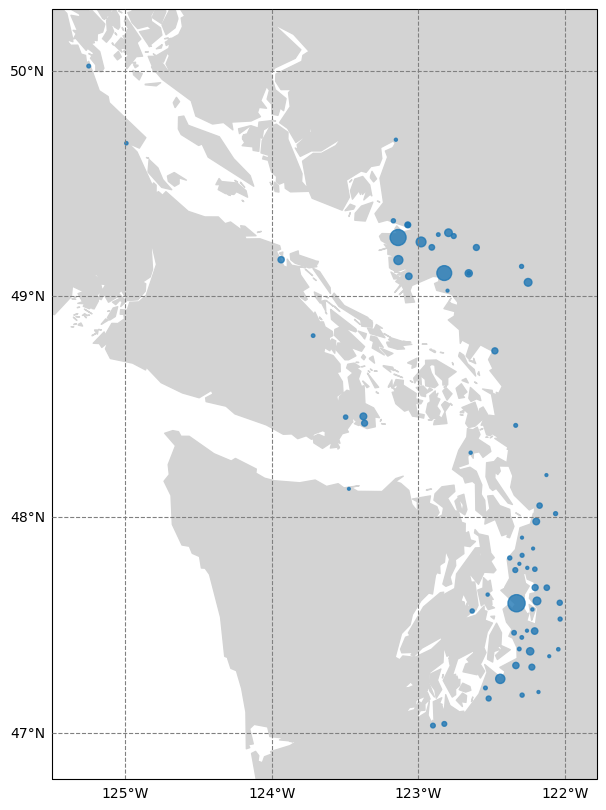

In [12]:
lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+0.25
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='lightgray',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Urban.Population/5e3)

In [13]:
Urban.shape

(68, 4)

In [29]:
import xarray as xr
from salishsea_tools import river_201702 as Rivers

In [50]:
rivers = Rivers.prop_dict
bathy = xr.open_dataset('~/MOAD/grid/grid/bathymetry_202108.nc')

In [92]:
River_Name = []
River_Watershed = []
Latitude = []
Longitude = []
for watershed in (rivers.keys()):
    for name in rivers[watershed].keys():
        River_Name.append(name)
        River_Watershed.append(watershed)
        Latitude.append(bathy.nav_lat[rivers[watershed][name]['i'],rivers[watershed][name]['j']].values)
        Longitude.append(bathy.nav_lon[rivers[watershed][name]['i'],rivers[watershed][name]['j']].values)
d = {'Name': River_Name, 'Watershed':River_Watershed,'Latitude':Latitude,'Longitude':Longitude}
Rivers_list = pd.DataFrame(data=d)

In [98]:
Rivers_list=Rivers_list.append({'Name':'Fraser North','Watershed':'fraser','Latitude':49.198219,'Longitude': -123.132636},ignore_index=True)

/tmp/ipykernel_20017/3380534636.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Rivers_list=Rivers_list.append({'Name':'Fraser North','Watershed':'fraser','Latitude':49.198219,'Longitude': -123.132636},ignore_index=True)


In [105]:
Rivers_list[Rivers_list['Watershed']=='fraser']

,Name,Watershed,Latitude,Longitude
87,Dakota,fraser,48.97305679321289,-122.75082397460938
88,Terrel,fraser,48.92045974731445,-122.75363159179688
89,Nooksack,fraser,48.766326904296875,-122.59487915039062
90,Squallum,fraser,48.75948715209961,-122.51393127441406
91,Lakethingo,fraser,48.75141525268555,-122.49340057373047
92,Chuckanut,fraser,48.72425842285156,-122.5112533569336
93,Fraser,fraser,49.116204,-123.189394
171,Fraser North,fraser,49.198219,-123.132636


In [107]:
#fixing main branch Fraser River Location
Rivers_list.iloc[93].Latitude = 49.116204 
Rivers_list.iloc[93].Longitude = -123.189394

In [130]:
colors_wsheds= {
'howe':'#F6D1BF', 
'jdf':'#AAA67E', 
'puget':'#FCF7B4',
'skagit':'#ACC752', 
'fraser':'#C0DCD1', 
'evi_n':'#B2C391', 
'jervis':'#CFCAD1', 
'toba':'#949B9D', 
'bute':'#AAD3E8', 
'evi_s':'#F0DCB4'}
cc = []
for i in range(Rivers_list.shape[0]):
    cc.append(colors_wsheds[Rivers_list.Watershed.iloc[i]])

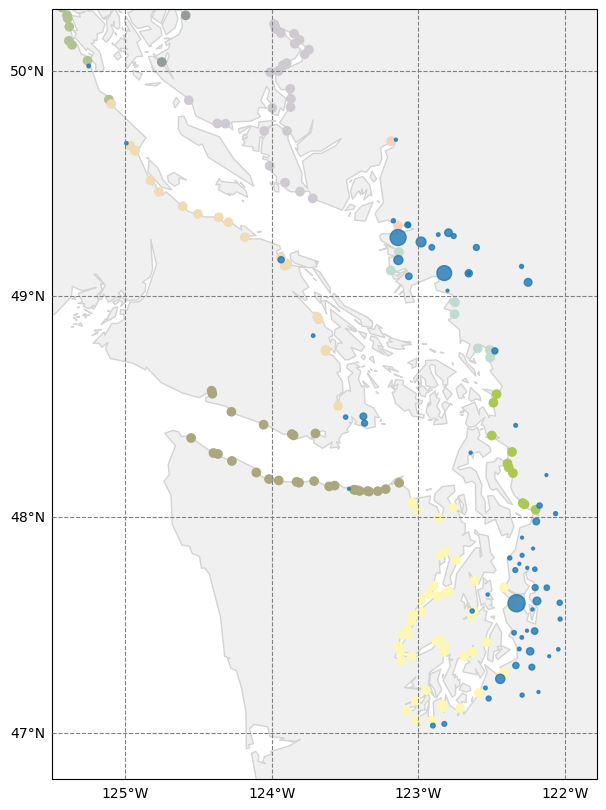

In [133]:
lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+0.25
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=3,alpha=0.8,s=Urban.Population/5e3)
riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=2,c = cc)